Epoch 1/10
20/20 [==============================] - 5s 185ms/step - loss: 1.7758 - jenis_output_loss: 0.6463 - warna_output_loss: 1.1295 - jenis_output_accuracy: 0.6312 - warna_output_accuracy: 0.5330 - val_loss: 1.0818 - val_jenis_output_loss: 0.5009 - val_warna_output_loss: 0.5809 - val_jenis_output_accuracy: 0.7756 - val_warna_output_accuracy: 0.8013
Epoch 2/10
20/20 [==============================] - 3s 172ms/step - loss: 0.8182 - jenis_output_loss: 0.4668 - warna_output_loss: 0.3514 - jenis_output_accuracy: 0.7568 - warna_output_accuracy: 0.8631 - val_loss: 0.9274 - val_jenis_output_loss: 0.5991 - val_warna_output_loss: 0.3284 - val_jenis_output_accuracy: 0.6538 - val_warna_output_accuracy: 0.9167
Epoch 3/10
20/20 [==============================] - 3s 174ms/step - loss: 0.5782 - jenis_output_loss: 0.4200 - warna_output_loss: 0.1582 - jenis_output_accuracy: 0.7987 - warna_output_accuracy: 0.9549 - val_loss: 0.7458 - val_jenis_output_loss: 0.4901 - val_warna_output_loss: 0.2557 - va

C:\Users\gabri\anaconda3\envs\tensor-env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


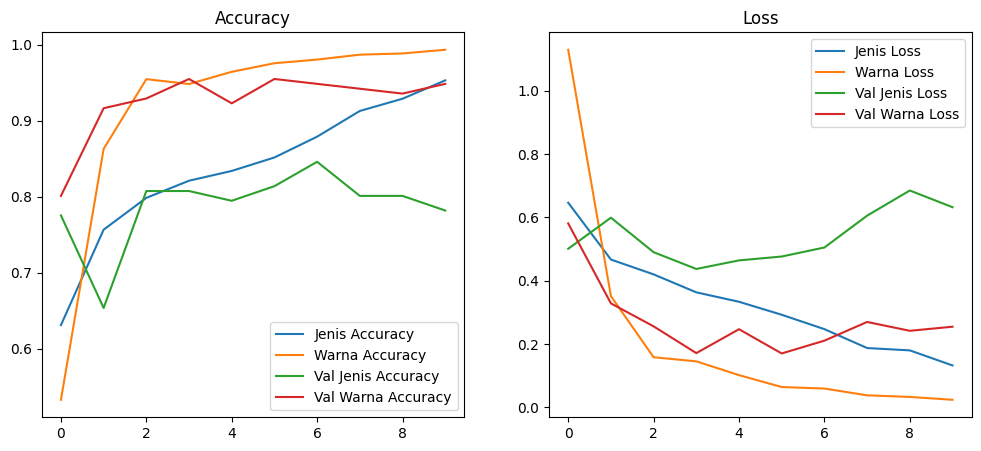

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths
train_img_folder = '../Penyisihan_Hology_DataMining/train'  # Update with the path to your train folder
csv_file = '../Penyisihan_Hology_DataMining/train.csv'  # Update with the path to your train.csv

# Image preprocessing constants
IMG_SIZE = (128, 128)

# Load train.csv
train_df = pd.read_csv(csv_file)

# Helper function to load images and preprocess
def load_images_from_folder(folder, img_ids, img_extensions=['.jpg', '.JPG', '.png']):
    images = []
    for img_id in img_ids:
        img_path = None
        # Loop through possible extensions to find a valid image file
        for ext in img_extensions:
            potential_path = os.path.join(folder, f"{img_id}{ext}")
            if os.path.exists(potential_path):
                img_path = potential_path
                break

        # If image file is found, load and preprocess it
        if img_path:
            img = load_img(img_path, target_size=(128, 128))  # Adjust IMG_SIZE as needed
            img_array = img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
        else:
            print(f"Image {img_id} not found in any supported format.")

    return np.array(images)

# Load image ids and labels from the CSV file
img_ids = train_df['id'].values
jenis_labels = train_df['jenis'].values
warna_labels = train_df['warna'].values

# Load images
images = load_images_from_folder(train_img_folder, img_ids)

# Convert the labels into categorical format
jenis_labels_cat = to_categorical(jenis_labels, num_classes=2)  # Binary: T-shirt (0) or Hoodie (1)
warna_labels_cat = to_categorical(warna_labels, num_classes=5)  # Colors: 1=Red, 2=Yellow, 3=Blue, 4=Black, 5=White

# Split the data into train and validation sets
X_train, X_val, y_train_jenis, y_val_jenis, y_train_warna, y_val_warna = train_test_split(
    images, jenis_labels_cat, warna_labels_cat, test_size=0.2, random_state=42
)

# Model architecture: Multi-output CNN
input_layer = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Flatten
flat = Flatten()(pool3)

# Output for 'jenis' (T-shirt or Hoodie)
jenis_output = Dense(2, activation='softmax', name='jenis_output')(flat)

# Output for 'warna' (Red, Yellow, Blue, Black, White)
warna_output = Dense(5, activation='softmax', name='warna_output')(flat)

# Define model
model = Model(inputs=input_layer, outputs=[jenis_output, warna_output])

# Compile the model
model.compile(optimizer='adam', 
              loss={'jenis_output': 'categorical_crossentropy', 'warna_output': 'categorical_crossentropy'}, 
              metrics={'jenis_output': 'accuracy', 'warna_output': 'accuracy'})

# Train the model
history = model.fit(X_train, {'jenis_output': y_train_jenis, 'warna_output': y_train_warna},
                    validation_data=(X_val, {'jenis_output': y_val_jenis, 'warna_output': y_val_warna}),
                    epochs=10, batch_size=32)

# Save the model
model.save('./base1_result/multilabel_model.h5')

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['jenis_output_accuracy'], label='Jenis Accuracy')
plt.plot(history.history['warna_output_accuracy'], label='Warna Accuracy')
plt.plot(history.history['val_jenis_output_accuracy'], label='Val Jenis Accuracy')
plt.plot(history.history['val_warna_output_accuracy'], label='Val Warna Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['jenis_output_loss'], label='Jenis Loss')
plt.plot(history.history['warna_output_loss'], label='Warna Loss')
plt.plot(history.history['val_jenis_output_loss'], label='Val Jenis Loss')
plt.plot(history.history['val_warna_output_loss'], label='Val Warna Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [3]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('./base1_result/multilabel_model.h5')

# Folder for test images
test_img_folder = '../Penyisihan_Hology_DataMining/test'  # Update with your actual path to test folder

# Load test images similar to how we loaded training images
test_img_ids = [file.split('.')[0] for file in os.listdir(test_img_folder)]  # Get image ids from test folder

# Load test images with the same function as before
test_images = load_images_from_folder(test_img_folder, test_img_ids)

# Perform predictions
predictions = model.predict(test_images)

# Split the predictions for 'jenis' and 'warna'
jenis_predictions = predictions[0].argmax(axis=1)  # Convert from one-hot to labels
warna_predictions = predictions[1].argmax(axis=1)  # Convert from one-hot to labels

# Create a DataFrame to store the results
result_df = pd.DataFrame({
    'id': range(778, 778 + len(test_img_ids)),  # Start IDs from 778
    'jenis': jenis_predictions,
    'warna': warna_predictions
})

# Save the results to CSV
result_df.to_csv('./base1_result/test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'.")


11/11 [==============================] - 0s 39ms/step
Predictions saved to 'test_predictions.csv'.
